# ECMs

This module contains different types of episodic and compositional memories (ECMs)

In [ ]:
#| default_exp ECMs

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# ECMs constructors

Here we collect different standalone functions that will help us construct different types of ECM

## ECM updaters

In [ ]:
#| export
def standard_ps_upd(reward, hmatrix, gmatrix, h_damp, g_damp):
    """
    Given a reward, updates h-matrix and g-matrix following the standard PS update rule:

    h <- h - h_damp*(h-1)+ reward*g
    g <- (1-g_damp)*g    
    """
    # damping h-matrix
    hmatrix = hmatrix - h_damp*(hmatrix-1.)
    # update h-matrix
    hmatrix += reward*gmatrix
    # update g-matrix
    gmatrix = (1-g_damp)*gmatrix

    return hmatrix, gmatrix

# Pre-built ECMs

Here we collect the abstract parent class that any ECM should be built upon as well as some pre-built ECM ready to use.

#| hide

## Abstract ECM

In [ ]:
#| export
from projective_simulation.methods.lib_helpers import CustomABCMeta
from abc import abstractmethod


class Abstract_ECM(metaclass = CustomABCMeta):
    """
    Abstract agent class any episodic and compositional memory (ECM) should be derived from. Asserts that the necessary methods are implemented.
    """

    def __init__(self):
        '''
        No restrictions on the constructor, as the ECM can be anything that has a sample module.
        '''
        pass

    @abstractmethod
    def sample(self,):
        """
        Performs a random walk through the ECM. Typically, this implies receiving an input percept and returning an action.
        """
        pass

In [ ]:
#| hide

### Test ###

class test_abstract(Abstract_ECM):

    def __init__(self, num_actions = 2):
        self.num_actions = num_actions

        super().__init__()

    # Here we do not define on purpose the sample method, to check if the abstract class raises an error when trying to instantiate it.
    # def sample(self):
    #     return 0

try:
    agent = test_abstract()  # This should raise a TypeError
except TypeError:
    print("Got the expected TypeError, test passed.")
else:
    raise AssertionError("TestAgent() did NOT raise TypeError but it should have.") 


Got the expected TypeError, test passed.


## Two Layer ECMs

### Basic Two Layer

In [ ]:
#| export
import numpy as np
from projective_simulation.methods.transforms import _softmax

class Two_Layer(Abstract_ECM):
    def __init__(self, 
                 # The number of available actions.
                 num_actions: int, 
                 # The glow damping(or eta) parameter. 
                 g_damp: float, 
                 # The damping (or gamma) parameter. 
                 h_damp: float,
                 # If 'greedy', uses a greedy policy that samples the most action based on the h-matrix. 
                 # If 'softmax', uses a softmax policy that samples an action based on the h-matrix and a temperature parameter (encoded in policy_parameters).
                 # If object, uses this object to sample action. Input must be h_values corresponding to current percept + arbitrary policy_parameters.
                 policy: str = 'greedy',                 
                 # The parameters of the policy.
                 policy_parameters: dict = None,
                 # Method to update the g-matrix. 
                 # If 'sum', adds the new value to the current value.
                 # If 'init', sets the new value to 1.
                 glow_method: str = 'sum',
                ):

        """
        Two layer ECM. First layer, encoding the percepts observed in an environment, is initially empty (e.g. self.num_percepts = 0). As percepts
        are observed, they are added to the ECM and to the percept dictionary self.percepts. 
        The second layer, encoding the actions, has size self.num_actions.
        In practice, the ECM graph is never created. Instead, it is defined indirectly by the h-matrix and g-matrix. 
        Both have size (self.num_percepts, self.num_actions). 
        The input policy (greedy, softmax or other) is used to sample actions based on the h-matrix.

        For an end-to-end example of how to use this class, see the tutorial notebook on Basic PS agents.        
        """

        

        self.num_actions = num_actions

        self.h_damp = h_damp
        self.g_damp = g_damp
        self.glow_method = glow_method

        self.policy = policy
        self.policy_parameters = policy_parameters
        
        # Initialize ECM structures

        #int: current number of percepts.
        self.num_percepts = 0
        #np.ndarray: h-matrix with current h-values. Defaults to all 1.
        self.hmatrix = np.ones([0,self.num_actions])
        #np.ndarray: g-matrix with current glow values. Defaults to all 0.
        self.gmatrix = np.zeros([0,self.num_actions])
        #dict: Dictionary of percepts as {"percept": index}
        self.percepts = {}

    def sample(self, percept: str):
        """
        Given a percept, returns an action and changes the ECM if necessary
        First, if the percept is new, it will be added to the ECM
        Then, an action is selected as a function of the percept and the h-values of edges connected to that percept
        Finally, the g-matrix is updated based on the realized percept-action pair.
        """

        # Add percept to ECM if not already present
        self.add_percept(percept)
        # Get index from dictionary entry
        percept_index = self.percepts[percept]
        # Get h-values
        h_values = self.hmatrix[percept_index]

        # Perform Random Walk through the ECM based on h_values and current policy
        if self.policy == 'greedy': 
            # Sample greedly the action with the highest h-value
            h_values = self.hmatrix[percept_index]
            action = h_values.argmax()   

        elif self.policy == 'softmax':
            # Get probabilities from h-values through a softmax function
            prob = _softmax(self.policy_parameters, h_values)
            # Sample action based on probabilities
            action = np.random.choice(range(self.num_actions), p=prob) 

        else:
            # This considers a custom policy
            action = self.policy(h_values = h_values, **self.policy_parameters)

        # Update g-matrix
        if self.glow_method == 'sum':
            self.gmatrix[int(percept_index),int(action)] += 1.
        if self.glow_method == 'init':
            self.gmatrix[int(percept_index),int(action)] = 1.
            

        return action

    def add_percept(self, percept):
        '''
        Checks if percept is in dictionary and adds to ECM in not
        '''
        if percept not in self.percepts.keys(): 
            self.percepts[percept] = self.num_percepts
            # increment number of percepts
            self.num_percepts += 1
            # add column to h-matrix
            self.hmatrix = np.append(self.hmatrix, 
                                     np.ones([1,self.num_actions]),
                                     axis=0)
            # add column to g-matrix
            self.gmatrix = np.append(self.gmatrix, 
                                    np.zeros([1,self.num_actions]),
                                    axis=0)

    def  learn(self, reward):
        """
        Updates the h-matrix and g-matrix based on the reward received using the standard PS update rule.
        """
        self.hmatrix, self.gmatrix = standard_ps_upd(reward, self.hmatrix, self.gmatrix, self.h_damp, self.g_damp)

In [ ]:
#| hide

### Test ###

# Greedy policy
ECM_2l_greedy = Two_Layer(4,1,1)
ECM_2l_greedy.sample(0)

# Softmax policy
ECM_2l_softmax = Two_Layer(4,1,1, policy = 'softmax', policy_parameters = 1)
ECM_2l_softmax.sample(0);

### Priming Two Layer

In [ ]:
#| export
from projective_simulation.methods import transforms

class Priming_ECM(Two_Layer):
    '''
    This sub-class of the Two-Layer ECM adds a variable for action priming.
    This variable should be a list of floats, each element of which corresponds to an action in the ECM.
    These "priming values" are summed with h-values of any edge connected to the associated action node prior to calculating walk probabilites with the softmax function
    '''
    def __init__(self, 
                 num_actions: int, # The number of available actions.                 
                 glow: float = 0.1, # The glow (or eta) parameter. 
                 damp: float = 0.01, # The damping (or gamma) parameter. 
                 softmax: float = 0.5, # The softmax (or beta) parameter.
                 action_primes: list = None, #weights on the probability that deliberation steps into each action. Defaults to 0 for each action 
                ):
        if action_primes is None:
            action_primes = [0.] * num_actions
        assert len(action_primes) == num_actions

        self.softmax = softmax
        super().__init__(num_actions, glow, damp, 
                         policy = None) # Here I made explicit that the policy is None, as we override the sample method
        self.action_primes = action_primes
        

    def sample(self, percept):
        '''
        Almost identical to the sample function of Two-Layer parent class, but sums h-values and action primes prior to calculating walk probabilities
        '''
        self.add_percept(percept)
        #Perform Random Walk
        # get index from dictionary entry
        percept_index = self.percepts[percept]
        # get h-values
        h_values = self.hmatrix[percept_index]
        #~~~Differences from two-layer sample function within
        assert len(h_values) == len (self.action_primes)
        # get probabilities from h-values and primes through a softmax function
        prob = transforms._softmax(self.softmax, h_values + self.action_primes)
        #~~~~~~~
        # get action
        action = np.random.choice(range(self.num_actions), p=prob)        
        #pdate g-matrix
        self.gmatrix[int(percept_index),int(action)] = 1.
        return action

#### Example

In [ ]:
#| hide
from projective_simulation.environments import RLGL
from projective_simulation.ECMs import Priming_ECM
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

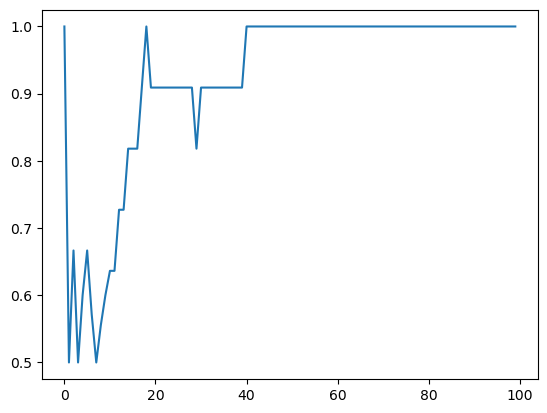

In [ ]:
test_ECM = Priming_ECM(num_actions = 2, action_primes = [0., 1.5])
#Number of steps to run simulation
T = 100
data_log = [None] * T
env = RLGL() #create a default red-light-green-light environment

for t in range(T):
    observation = env.get_observation()
    action = test_ECM.sample(observation)
    reward = env.get_reward(action)
    test_ECM.learn(reward)
    data_log[t] = {"env_state": env.state, "action": action, "reward": reward}
    env.transition(action)

plt.plot(range(T), [np.mean([data_log[step]["reward"] for step in range(i-10,i+1) if step >= 0]) for i in range(T)]) #plot a 10 step moving average of the reward 

## Situated Projective Simulation

### Predictive Bayesian Network

In [ ]:
#| export
import numpy as np

class Bayesian_Network(Abstract_ECM):
    """
    Bayesian Network ECM implementation.
    """

    def __init__(
        self,
        W: list,       # a list of np.arrays,
        C_matrix: np.ndarray,       # Transition matrix between m-level nodes.
        m_expectation: np.ndarray = None,  # Optional initial expectation distribution over m-nodes.
        data_log: bool = False       #stores surprise after each network excitation in a list
    ):
        super().__init__()       
        self.percept_category_sizes = [np.shape(W_matrix)[0] for W_matrix in W]
        self.num_m_nodes = np.shape(C_matrix)[1]              
        self.W = W
        for W_matrix in W:
            if not np.shape(W_matrix)[1] == np.shape(C_matrix)[1]:
                raise ValueError("W_matrices and C_matrix must have the same number of columns (m_nodes)")
        if not np.shape(C_matrix)[0] == np.shape(C_matrix)[1]:
            raise ValueError("C_matrix must have the same number of columns and rows (m_nodes)")
        self.C_matrix = C_matrix

        self.surprise_data = [] if data_log else None

        # Initialize sensory and m-level excitations as empty arrays
        self.percept = np.empty(len(self.percept_category_sizes))
        self.m_excitation = np.empty(self.num_m_nodes)

        # Set the initial expectation to uniform if none is provided
        self.m_expectation = np.full(self.num_m_nodes, fill_value=1/self.num_m_nodes) if m_expectation is None else m_expectation

        # Compute initial sensory expectation as a weighted sum over W_matrix
        self.sensory_expectation =   [np.dot(self.m_expectation, W_matrix.T) for W_matrix in self.W]

        # Placeholder for current m-node activation vector
        self.m_activation = np.zeros(self.num_m_nodes)

    def excite_network(
        self,
        percept: np.ndarray  # Binary input vector representing the current percept.
    ):
        """Sets the sensory excitation equal to the percept vector and updates m_excitation accordingly."""
        # Check input shape
        if percept.shape[0] != self.num_sensory_elements:
            raise ValueError("Percept vector size does not match the number of sensory elements.")

        self.percept = percept

        # compute each m_excitation as the product of each sensory element's excitation likelihood,
        categorical_likelihoods = np.vstack([W_matrix[category_state] for W_matrix, category_state in zip(self.W, self.percept)]) #likilihood of percept categories (rows) given memory (columns)
        self.m_excitation = np.prod(categorical_likelihoods, axis=0) #likelihood of percept given memory by taking product of values in each column

    def activate(self):
        """Sets m_activation based on m_excitation and m_expectation."""
        # Compute the unnormalized activation (Bayesian inference numerator)
        numerator = self.m_excitation * self.m_expectation

        # Normalize to ensure it sums to one (Bayesian posterior)
        denominator = np.sum(numerator)

        if denominator != 0:
            self.m_activation = numerator / denominator
        else:
            # Avoid division by zero if all values are 0
            print("Warning: Activations sum to 0. This implies the agent believes it can not be in any known state and is likely to cause problems")
            self.m_activation = np.zeros(self.num_m_nodes)

    def set_expectations(self):
        """Set m_expectation and sensory_expectation based on activation and weight matrices."""
        
        # Normalize the C_matrix rows to form proper probability distributions
        row_sums = self.C_matrix.sum(axis=1, keepdims=True)
        normalized_C_matrix = np.divide(self.C_matrix, row_sums, where=row_sums != 0)

        # Update m_expectation using the transition matrix and current activation
        self.m_expectation = np.dot(self.m_activation, normalized_C_matrix)

        # Update sensory_expectation using a transformed dot product with W_matrix
        self.sensory_expectation = [np.dot(self.m_expectation, W_matrix.T) for W_matrix in self.W]

    def get_surprise(self) -> float:
        """Compute the total surprise of the network."""
        # Compute the surprise of each element using the binary cross-entropy formula
        percept_probs = [self.sensory_expectations[k][self.percept[k]] for k in range(len(self.percept_category_size))]
        surprise_values = -np.log2(percept_probs)

        # Return total surprise as the sum over all sensory elements
        return np.sum(surprise_values)

    def sample(self, percept) -> np.ndarray:
        '''given a percept, updates network states and returns a vector of sensory expectations'''
        self.excite_network(percept)
        if not self.surprise_data is None:
            self.surprise_data = self.surprise_data + [self.get_surprise()]
        self.activate()
        self.set_expectations()
                                           
        return self.sensory_expectation

#### Example

In this example, we set up an environment that alternates between flipping a pair of biased coins and a pair of fair coins. The Bayesian Network's W-matrix gives it the probabilities of the coin flips in each state, and the C-matrix gives it the alternating state sequence pattern. The network does not know which state the system starts in, however. By recording and plotting the predictions the Bayesian Network, we can see how accumulating sensory evidence over times allows the Bayesian Network to establish which state the system is in and make accurate state-based predictions about the next flips.

In [ ]:
#Set up Paramters 
T = 100 
W_matrix = np.array(([0.6,0.5],   #frist coin probabilities in biased and fair states
                     [0.4,0.5]))  #second coin probabilities in biased and fair states
C_matrix = np.array(([0,1],[1,0])) #state transition probabilities

#Create variable for storing prediction data an initialize bayesian network instance
predictions = np.zeros((T,np.shape(W_matrix)[0])) #time steps by number of sensory elements
test_bayesian_net = Bayesian_Network(W_matrix, C_matrix)
    
for t in range(T):
    if t % 2 == 0: #biased state first
        percept = np.random.binomial(n = 1, p = W_matrix[:,0])
    else:          #fair state second
        percept = np.random.binomial(n = 1, p = W_matrix[:,1])
    
    predictions[t,:] = test_bayesian_net.sample(percept)

IndexError: tuple index out of range

In [ ]:
"""
Plot the predicted probabilities over time
"""
plt.figure(figsize=(10, 5))
plt.plot(range(T), predictions[:,0], label='Coin 1', linewidth=2, color='deepskyblue')
plt.plot(range(T), predictions[:,1], label='Coin 2', linewidth=2, color='darkblue')

plt.xlabel("Time (T)")
plt.ylabel("Predicted Probability (Heads)")
plt.title("Network Predictions - Alternating Bias Environment")
plt.legend(loc = 2)
plt.show()

### Bayesian Memory Network

In [ ]:
#|export

from projective_simulation.methods.transforms import _logistic, _shifted_exponent
import numpy as np

class Bayesian_Memory(Bayesian_Network):
    """
    BayesianMemory is a memory-augmented extension of the BayesianNetwork.
    It supports dynamic modification of internal weights to encode temporal traces.
    """
    def __init__(
        self,
        num_sensory_elements: int,        # Number of sensory input elements.
        num_m_nodes: int,                 # Number of memory nodes.
        W_matrix: np.ndarray = None,     # Optional sensory-to-memory weight matrix.
        C_matrix: np.ndarray = None,     # Optional memory transition matrix.
        timer: int = 0,                  # Starting memory time index.
        sensory_evidence_prior: float = 1,  # Strength of sensory evidence.
        continuity_prior: float = 0.95,      # Prior for trace continuity.
        data_log = False,
        sensory_epsilon: float = 0.0001, #shifts sensory expectations to avoid absolutes. Should be very small
    ):
        # Default to informationless sensory weights if none provided
        if W_matrix is None:
            W_matrix = np.full((num_sensory_elements, num_m_nodes), fill_value=0.5)

        # Default to uniform transitions if none provided
        if C_matrix is None:
            C_matrix = np.zeros((num_m_nodes, num_m_nodes))

        super().__init__(W_matrix = W_matrix, C_matrix = C_matrix, data_log = data_log)

        self.timer = timer
        self.sensory_evidence_prior = sensory_evidence_prior
        self.continuity_prior = continuity_prior
        self.sensory_epsilon = sensory_epsilon

    def encode_memory(self):
        """
        Modify W_matrix and C_matrix to encode the current percept into memory.
        This sets the current memory trace's excitation weights and transition weights.
        """
        # Encode current sensory excitation into the W_matrix at this memory step
        self.W_matrix[:, self.timer] = self.sensory_excitation

        # Set C_matrix column for this trace with uniform transition probability
        self.C_matrix[:, self.timer] = (1 - self.continuity_prior) / (self.num_m_nodes - 1)

        # Enhance the transition from previous step to this one
        if self.timer > 0:
            self.C_matrix[self.timer - 1, self.timer] = self.continuity_prior

        # Inhibit the excitation of the currently encoded trace
        self.m_excitation[self.timer] = 0

    def excite_network(
        self,
        percept: np.ndarray  # Binary input vector representing the current percept.
    ):
        """
        Similar to function of same name for Bayesian_Network, except logistic transformation is applied to sensory evidence weights.
        This adds uncertainty as a function of the sensory evidence prior
        """
        # Check for dimensional mismatch
        if percept.shape[0] != self.num_sensory_elements:
            raise ValueError("Percept vector size does not match the number of sensory elements.")

        # Store percept as current sensory excitation
        self.sensory_excitation = percept

        # Apply logistic transformation to add uncertaint to sensory evidence
        weighted_evidence = _logistic(self.W_matrix, x_shift=0.5, k=self.sensory_evidence_prior)

        # Compute m-level excitation using product of evidence probabilities
        self.m_excitation = np.prod(
            np.power(weighted_evidence, self.sensory_excitation[:, np.newaxis]) *
            np.power(1 - weighted_evidence, (1 - self.sensory_excitation)[:, np.newaxis]),
            axis=0
        )

    def set_expectations(self):
        """
        Applies shifted exponential to sensory predictions, preventing 'absolute certainty'
        """
        super().set_expectations()
        self.sensory_expectation = _shifted_exponent(x = self.sensory_expectation, k = 0, epsilon = self.sensory_epsilon)

    def sample(self, percept):
        self.excite_network(percept)
        if not self.surprise_data is None:
            self.surprise_data = self.surprise_data + [self.get_surprise()]
        self.encode_memory()
        self.activate()
        self.set_expectations()

        # Return the index of the maximum activated node (greedy policy)
        self.timer = (self.timer + 1) % self.num_m_nodes
        return self.sensory_expectation
    

#### Example

In this example, we set up an environment that alternates between flipping a pair of biased coins and a pair of fair coins.

In [ ]:
#Set up Paramters 
T = 200
flip_probs = np.array(([0.8,0.5],   #first coin probabilities in biased and fair states
                     [0.2,0.5]))  #second coin probabilities in biased and fair states

num_sensors = flip_probs.shape[0]
num_traces = 100
#Create variable for storing prediction data an initialize bayesian network instance
predictions = np.zeros((T,num_sensors)) #time steps by number of sensory elements
test_bayesian_memory = Bayesian_Memory(num_sensory_elements = num_sensors, 
                                       num_m_nodes = num_traces,
                                       sensory_evidence_prior = 0.4,
                                       continuity_prior = 0.98
                                      )
    
for t in range(T):
    if t % 2 == 0: #biased state first
        percept = np.random.binomial(n = 1, p = flip_probs[:,0])
    else:          #fair state second
        percept = np.random.binomial(n = 1, p = flip_probs[:,1])
    
    predictions[t,:] = test_bayesian_memory.sample(percept)

In [ ]:
"""
Plot the predicted probabilities over time
"""
plt.figure(figsize=(10, 5))
plt.plot(range(T), predictions[:,0], label='Coin 1', linewidth=2, color='deepskyblue')
plt.plot(range(T), predictions[:,1], label='Coin 2', linewidth=2, color='darkblue')

plt.xlabel("Time (T)")
plt.ylabel("Predicted Probability (Heads)")
plt.title("Network Predictions - Alternating Bias Environment")
plt.legend(loc = 2)
plt.show()

#| hide
# nbdev export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()